# Data extraction

Send request for BTC pricing data and store response locally.

In [4]:
import requests

response = requests.get("https://www.satochi.co/allBTCPrice")

with open("btc_raw.txt","wb") as file:
    file.write(response.content)

Convert response data into DataFrame

In [5]:
import pandas as pd

with open("btc_raw.txt", "rb") as file:
    btc = pd.read_json(file)
    
btc.columns = ["date","btc"]
btc["date"] = pd.to_datetime(btc["date"])
btc = btc.set_index("date")

Send request for VT, BND and IGOV pricing data and store responses locally

In [6]:
wsj_api = "https://www.wsj.com/market-data/quotes/etf/{}/historical-prices/download?MODVIEW=page&num_rows=8000&range_days=8000"

etfs = ["vt","bnd","igov"]

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"}

for etf in etfs:
    response = requests.get(wsj_api.format(etf),headers=headers)
    with open(etf+"_raw.csv","wb") as file:
        file.write(response.content)

Convert responses into DataFrames

In [7]:
def csv_read(etf):
    df = pd.read_csv(etf+"_raw.csv")
    df = df.loc[:,["Date"," Close"]]
    df.columns = ["date", etf]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    
    return df

vt = csv_read("vt")
bnd = csv_read("bnd")
igov = csv_read("igov")

# Data preparation

Create bond index that's 50/50 weighted between BND and IGOV

In [8]:
bonds = pd.concat([bnd,igov], axis=1)

bonds["bonds"] = (bonds["bnd"] + bonds["igov"]) / 2

bonds = bonds.drop(["bnd","igov"], axis=1)

bonds = bonds.dropna()

Combine all dataframes into a single one

In [9]:
combined_df = pd.concat([btc,vt,bonds], axis=1)

columns = ["btc","equities","bonds"]
combined_df.columns = columns

Take out first rows until all are not `NaN`

In [10]:
df_start = combined_df[
    (combined_df["btc"]>0) & (combined_df["bonds"]>0) 
    & (combined_df["equities"]>0)].index[0]

combined_df = combined_df.loc[df_start:]

Fill `NaN` values

In [11]:
combined_df = combined_df.fillna(method="ffill")

Finalise 

In [12]:
import numpy as np

for col in columns:
    combined_df[col+"-log"] = np.log(combined_df[col])
    
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

corr_df = combined_df.rolling(window=356).apply(my_fun).iloc[356:,3:]
corr_df.columns = ["Bitcoin", "Equities", "Bonds"]

# Correlation matrix chart

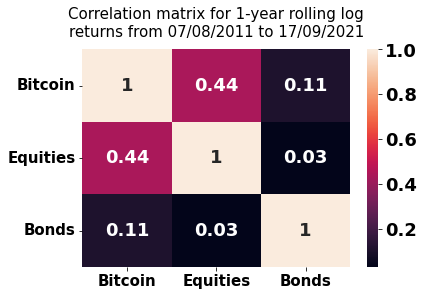

In [13]:
import matplotlib.pyplot as plt
import seaborn as sn

corr = corr_df.corr()

params = {
    "axes.facecolor":"white",
    "figure.facecolor":"white",
    "font.size": 18,
    "font.weight": 1000,
    "axes.titlepad": 13,
}

plt.rcParams.update(params)

start_date = corr_df.index[0].strftime("%d/%m/%Y")
end_date = corr_df.index[-1].strftime("%d/%m/%Y")

title = "Correlation matrix for 1-year rolling log\nreturns from {} to {}".format(start_date,end_date)

res = sn.heatmap(corr, annot=True)

res.set_title(title,fontsize=15)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 15)

plt.yticks(rotation=0)

plt.savefig("btc-corr.png",bbox_inches='tight')

# Correlation changes over time

Split the combined dataframe by year

In [26]:
corr_copy = corr_df.copy()

corr_copy['year'] = corr_copy.index.year

years = corr_copy["year"].unique()

split_df = [{"year":y,"df":corr_copy[corr_copy['year'] == y]} for y in years]

Create dataframe for correlation matrices

In [27]:
hist = pd.DataFrame(data=[[x["year"],
 x["df"]["Bitcoin"].corr(x["df"]["Equities"]),
 x["df"]["Bitcoin"].corr(x["df"]["Bonds"]),
 x["df"]["Bonds"].corr(x["df"]["Equities"])]
 for x in split_df],
             columns=["Year","BTC/EQT","BTC/BND","EQT/BND"])

hist.iloc[:,1:] = hist.iloc[:,1:] * 100
hist = hist.set_index("Year")

<AxesSubplot:xlabel='Year'>

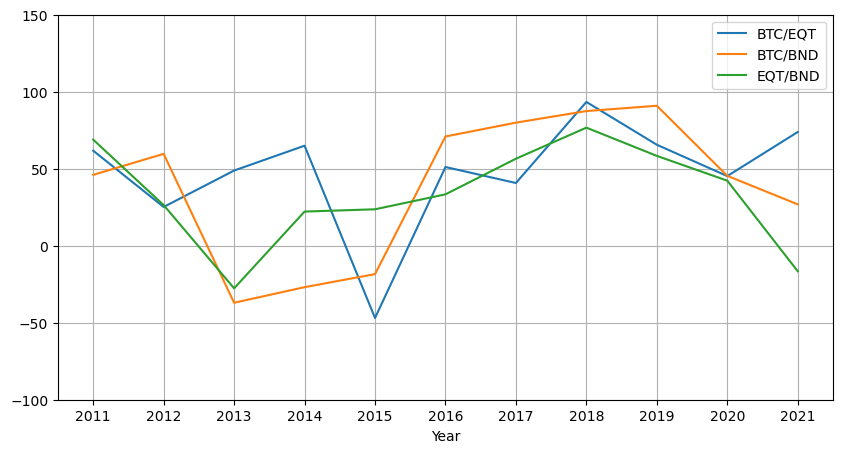

In [28]:
hist.plot(ylim=(-100,150),xticks=years,figsize=(10,5),grid=True)